In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ipykernel ipywidgets opencv-python antspyx SimpleITK antspynet

: 

In [ ]:
import os
from scipy import ndimage
import tqdm
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import pandas as pd
import os
import ants
import SimpleITK as sitk
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np
import SimpleITK as sitk
import cv2
from helpers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from antspynet.utilities import brain_extraction
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation

: 

In [ ]:
# Raw image loading

shape = (256, 256, 192) -> (Z, X, Y)


interactive(children=(IntSlider(value=127, description='SLICE', max=255), Output()), _dom_classes=('widget-int…

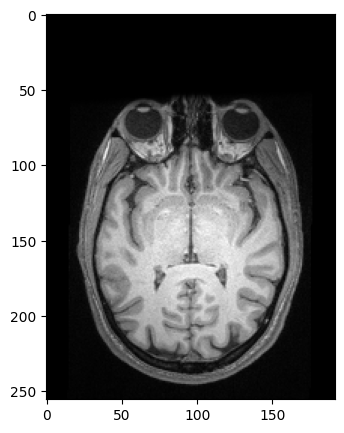

In [34]:
raw_img_path = "/content/drive/MyDrive/AICTE_FDP/control/0040013_session_1.nii.gz"
raw_img_ants = ants.image_read(raw_img_path, reorient='IAL')

print(f'shape = {raw_img_ants.numpy().shape} -> (Z, X, Y)')

explore_3D_array(arr=raw_img_ants.numpy(), cmap='gray')

In [23]:
# Brain mask generation

In [27]:
prob_brain_mask = brain_extraction(raw_img_ants, verbose=True,modality ='t1')

Brain extraction:  retrieving model weights.
5683832/5683832 [==============================] - 1s 0us/step
Brain extraction:  retrieving template.
14969865/14969865 [==============================] - 1s 0us/step
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 [==============================] - 23s 23s/step
Brain extraction:  renormalize probability mask to native space.


ANTsImage (IAL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 192)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (104.8374, -166.1083, -123.5326)
	 Direction  : [-0.0488 -0.0419 -0.9979 -0.002   0.9991 -0.0418  0.9988  0.     -0.0488]



interactive(children=(IntSlider(value=127, description='SLICE', max=255), Output()), _dom_classes=('widget-int…

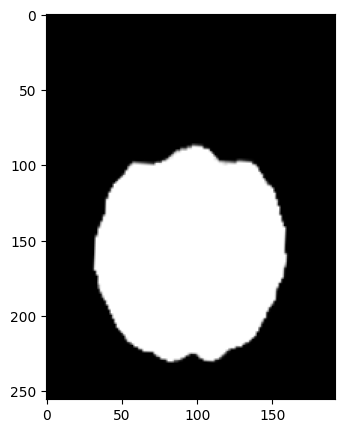

In [28]:
print(prob_brain_mask)
explore_3D_array(prob_brain_mask.numpy())

In [29]:
brain_mask = ants.get_mask(prob_brain_mask, low_thresh=0.5)

interactive(children=(IntSlider(value=127, description='SLICE', max=255), Output()), _dom_classes=('widget-int…

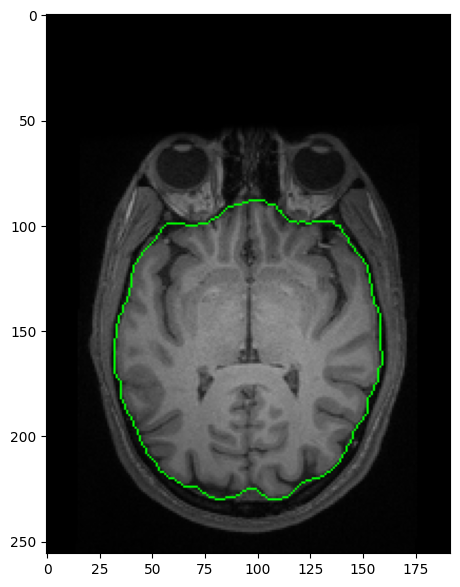

In [30]:
explore_3D_array_with_mask_contour(raw_img_ants.numpy(), brain_mask.numpy())

interactive(children=(IntSlider(value=127, description='SLICE', max=255), Output()), _dom_classes=('widget-int…

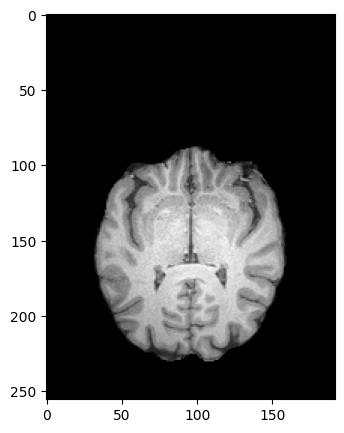

In [31]:
masked = ants.mask_image(raw_img_ants, brain_mask)

explore_3D_array(masked.numpy())

In [42]:
def load_nifti(folder):
    data = []
    filenames = list(os.listdir(folder))
    for filename in tqdm.tqdm(filenames):
        if filename.endswith(".nii.gz"):
            file_path = os.path.join(folder, filename)
            img = nib.load(file_path).get_fdata()
            # img = normalize(img)
            # img = resize_volume(img)
            data.append(img)
    return data

In [43]:
# Load data
hc_folder = r"/content/drive/MyDrive/AICTE_FDP/control_skullRemoved"
sc_folder = r"/content/drive/MyDrive/AICTE_FDP/schizophrenic_skullRemoved"
hc_data = load_nifti(hc_folder)
hc_labels = np.zeros(len(hc_data))

sc_data = load_nifti(sc_folder)
sc_labels = np.ones(len(sc_data))

# data = np.concatenate([class_0_data, class_1_data], axis=0)
# classes = np.concatenate([class_0_labels, class_1_labels], axis=0)

# X,y = data, classes

100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


In [ ]:
explore_3D_array(arr=hc_data[0], cmap='gray')

In [46]:
def get_roi(data):
  top =251
  bottom = 0
  for img in data:
      i =0
      while(np.all(img[i]==0)):
          i+=1
      top = min(top,i)
      j=251
      while(np.all(img[j]==0)):
              j-=1
      bottom = max(bottom,j)
  return top,bottom

In [50]:
top, bottom = get_roi(np.concatenate([hc_data, sc_data], axis=0))
def reshape_depth(img):
    img = img[top : bottom]
    return img

In [67]:
top,bottom

(48, 213)

In [53]:
def remove_black_layers(data):
  new_data = []
  for img in data:
    new_img = reshape_depth(img)
    new_data.append(new_img)
  return np.array(new_data)

In [61]:
hc_filter = remove_black_layers(hc_data)
sc_filter = remove_black_layers(sc_data)
print("Layers Removed = ", (256 -(bottom-top)))
print("Reduction in layers = ", ((256 -(bottom-top))/256*100),"%")

Layers Removed =  91
Reduction in layers =  35.546875 %


In [62]:
# One Healthy and One Patient brain vosualization and differences

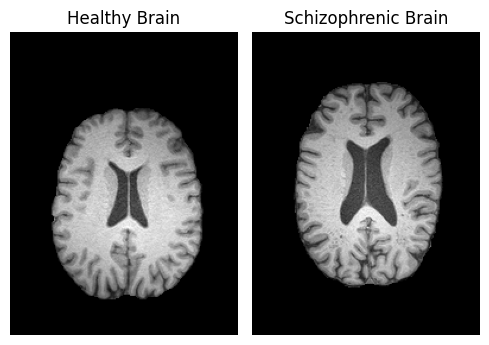

In [119]:
hc = hc_filter[1]
sc = sc_filter[4]
figures = [
    hc[83],sc[100]
]
titles = ["Healthy Brain", "Schizophrenic Brain"]

fig, axs = plt.subplots(1,2,figsize=(5,6))

for i, ax in enumerate(axs.flat):
    ax.imshow(figures[i],cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# 3D CNN Section starts from here

In [132]:

def normalize(arr):
    """Normalize the volume"""
    scaler = MinMaxScaler()
    scaler.fit_transform(arr.reshape(-1, arr.shape[-1])).reshape(arr.shape)
    return arr

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 128
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[0]
    current_width = img.shape[2]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (depth_factor, height_factor, width_factor), order=1)
    return img

In [150]:
# Normalizing and Resizing
data = np.concatenate([hc_filter, sc_filter], axis=0)
labels = np.concatenate([hc_labels, sc_labels], axis=0)
norm_resized_data = []
for img in tqdm.tqdm(data):
    img = normalize(img)
    img = resize_volume(img)
    norm_resized_data.append(img)
norm_resized_data = np.array(norm_resized_data)


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


(10, 128, 128, 128)

In [155]:
print("Shape of original image", hc_data[0].shape)
print("Shape of processed image", norm_resized_data[0].shape)

Shape of original image (256, 256, 192)
Shape of processed image (128, 128, 128)


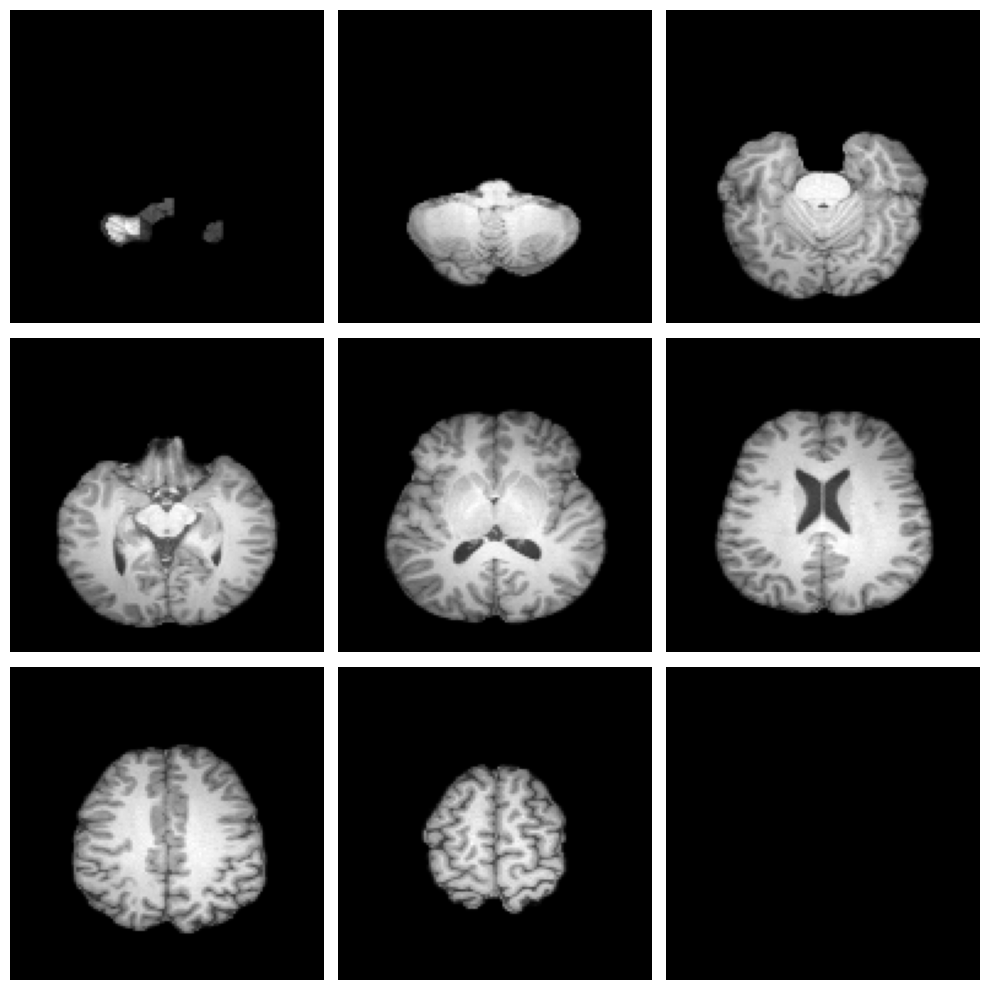

In [149]:
sample = norm_resized_data[6]

fig_rows = 3
fig_cols = 3
n_subplots = fig_rows * fig_cols
n_slice = sample.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow((sample[img,:, :]), cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

In [162]:
def get_model(depth=128, height=128, width=128):
    """Build a 3D convolutional neural network model."""

    inputs = tf.keras.Input((depth, height, width, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu",padding="same")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = tf.keras.Model(inputs, outputs, name="3dcnn")
    return model




In [163]:
X_train, X_test, y_train, y_test = train_test_split(norm_resized_data, labels, test_size=0.3, random_state=42)

In [167]:
# Create the 3D CNN model
model = get_model(128, 128, 128)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "cobre_checkpoint.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 128,    0         
                             1)]                                 
                                                                 
 conv3d_20 (Conv3D)          (None, 128, 128, 128, 6   1792      
                             4)                                  
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 64, 64, 64, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, 64, 64, 64, 64)    256       
 chNormalization)                                                
                                                                 
 global_average_pooling3d_5  (None, 64)                0     

In [165]:
history = model.fit(np.array(X_train), y_train, batch_size = 1, epochs=5, validation_data=(np.array(X_test), y_test))

Epoch 1/5
7/7 [==============================] - 105s 15s/step - loss: 0.6938 - acc: 0.4286 - precision_4: 0.3333 - recall_4: 0.3333 - auc_4: 0.5000 - val_loss: 0.9305 - val_acc: 0.3333 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.5000
Epoch 2/5
7/7 [==============================] - 102s 15s/step - loss: 0.6923 - acc: 0.5714 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.5000 - val_loss: 0.8607 - val_acc: 0.3333 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.5000
Epoch 3/5
7/7 [==============================] - 100s 15s/step - loss: 0.6934 - acc: 0.5714 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.1250 - val_loss: 0.8145 - val_acc: 0.3333 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.5000
Epoch 4/5
7/7 [==============================] - 100s 15s/step - loss: 0.6898 - acc: 0.5714 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.6250 - val_loss: 0.7832 - val_acc: 0.3333 -

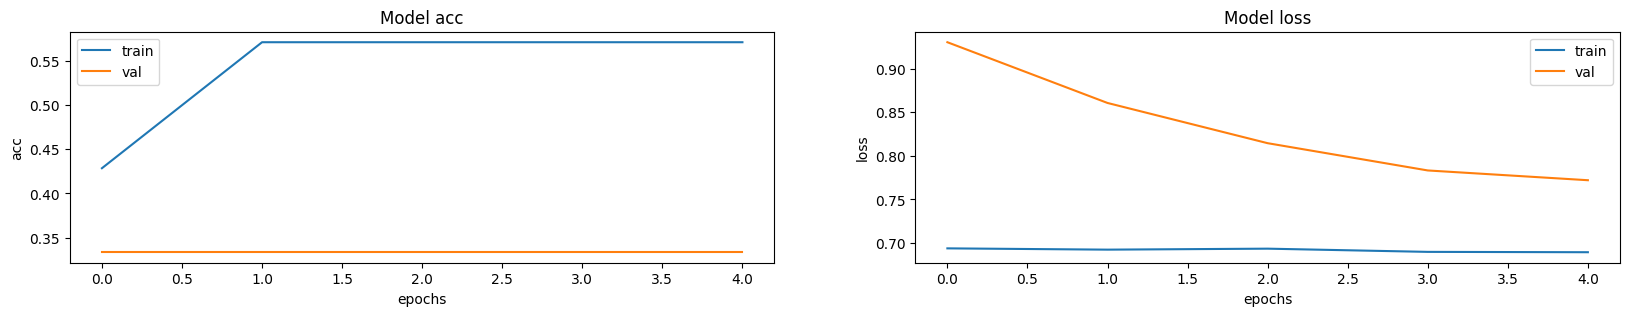

In [166]:
# Model from nature article
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
sample = X[1] # First image
sample.shape

(256, 256, 192)

In [ ]:
np.all(sample[0]==0), sample[0].shape

(True, (256, 192))

In [ ]:
i =0
while(np.all(sample[i]==0)):
    i+=1
print(i)

61


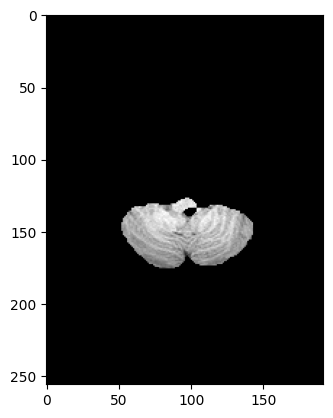

In [ ]:
plt.imshow(sample[66], cmap='gray')
plt.show()

In [ ]:

top =251
bottom = 0
for x in X:
    i =0
    while(np.all(x[i]==0)):
        i+=1
    top = min(top,i)
    j=251
    while(np.all(x[j]==0)):
            j-=1
    bottom = max(bottom,j)




In [ ]:
print(top,bottom)

48 213


In [ ]:
reduced_sample = sample[top:bottom]
reduced_sample.shape

(165, 256, 192)

In [ ]:
i =sample.shape[0] -1
while(np.all(sample[i]==0)):
    i-=1
print(i)

182


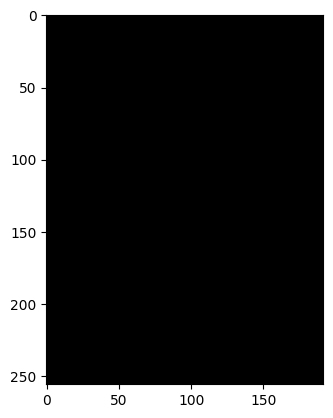

In [ ]:
plt.imshow(sample[206], cmap='gray')
plt.show()

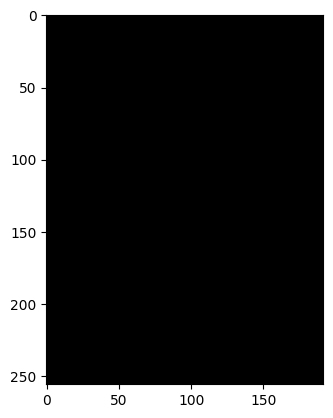

In [ ]:
plt.imshow(sample[207], cmap='gray')
plt.show()

In [ ]:
reduced_sample = sample[66:206]
reduced_sample.shape

(140, 256, 192)

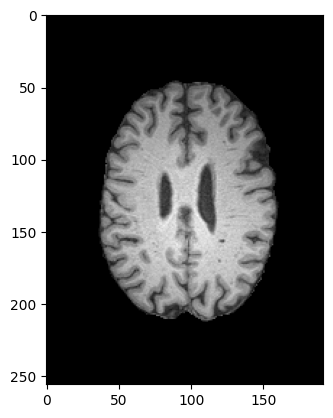

In [ ]:
plt.imshow(reduced_sample[90], cmap='gray')
plt.show()

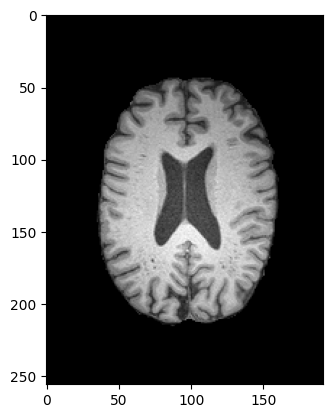

In [ ]:
plt.imshow(sample[150], cmap='gray')
plt.show()

In [ ]:
# sample[0]

In [ ]:
sample_hwd = np.moveaxis(reduced_sample,0,-1)
sample_hwd.shape

(256, 192, 140)

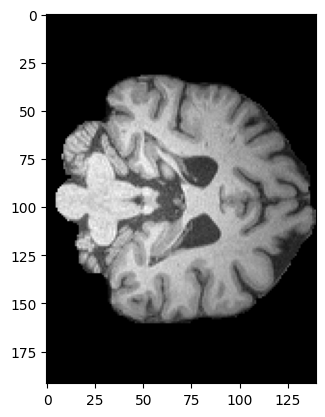

In [ ]:
plt.imshow(sample_hwd[150], cmap='gray')
plt.show()

In [ ]:
i =0
while(np.all(sample_hwd[i]==0)):
    i+=1
print(i)

41


In [ ]:
i =sample_hwd.shape[0]-1
while(np.all(sample_hwd[i]==0)):
    i-=1
print(i)

223


In [ ]:
reduced_sample_hwd = sample_hwd[41:223]
reduced_sample_hwd.shape

(182, 192, 140)

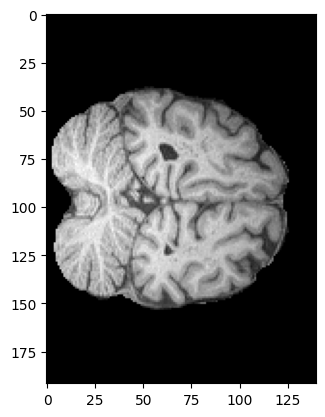

In [ ]:
plt.imshow(reduced_sample_hwd[140], cmap='gray')
plt.show()

In [ ]:
sample_wdh = np.moveaxis(reduced_sample_hwd,0,-1)
sample_wdh.shape

(192, 140, 182)

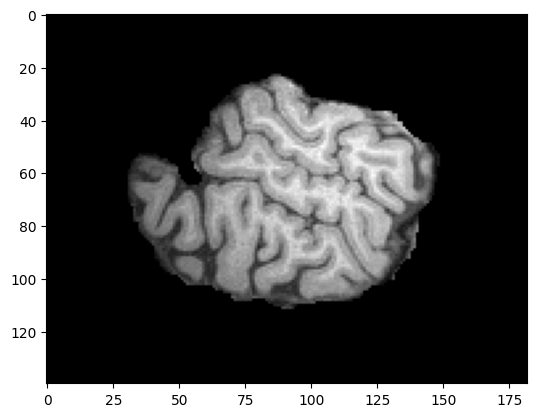

In [ ]:
plt.imshow(sample_wdh[150], cmap='gray')
plt.show()

In [ ]:
i =0
while(np.all(sample_wdh[i]==0)):
    i+=1
print(i)

31


In [ ]:
i =sample_wdh.shape[0]-1
while(np.all(sample_wdh[i]==0)):
    i-=1
print(i)

162


In [ ]:
reduced_sample_wdh = sample_hwd[31:162]
reduced_sample_wdh.shape

(131, 192, 140)

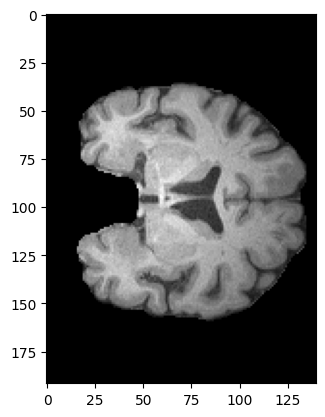

In [ ]:
plt.imshow(reduced_sample_wdh[80], cmap='gray')
plt.show()

In [ ]:
reduced_dhw = np.moveaxis(reduced_sample_wdh,0,-1)
reduced_dhw.shape

(192, 140, 131)

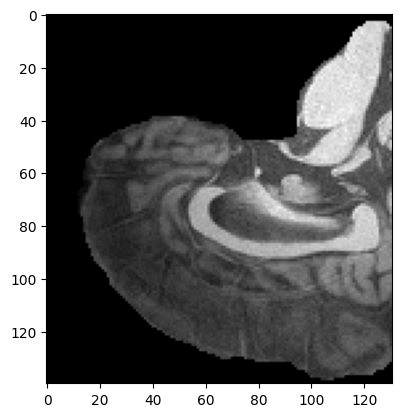

In [ ]:
plt.imshow(reduced_dhw[96], cmap='gray')
plt.show()

In [ ]:
brain_vol = X[0]

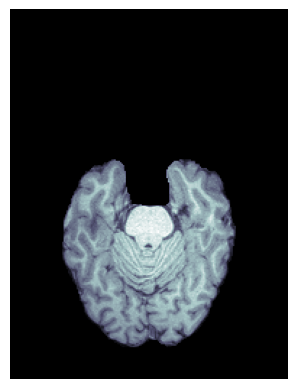

In [ ]:
plt.imshow(X[0][100], cmap='bone')
plt.axis('off')
plt.show()

In [ ]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

0
16
32
48
64
80
96
112
128
144
160
176
192
208
224
240


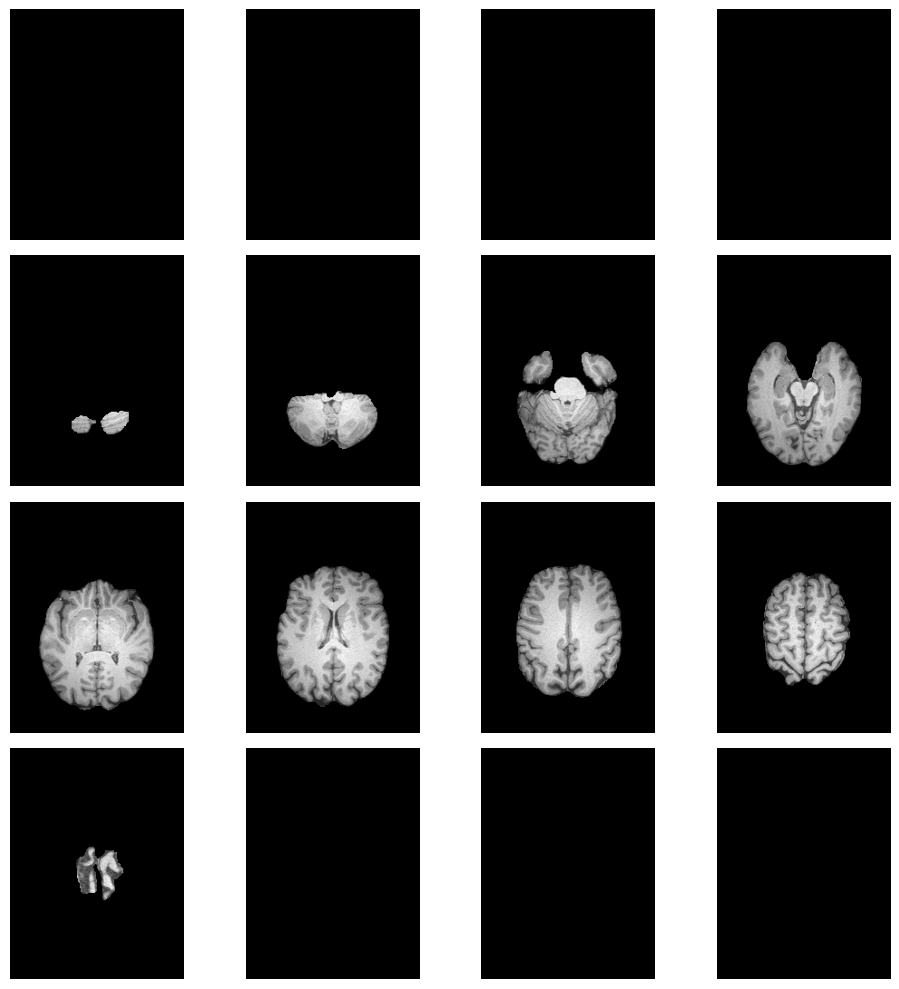

In [ ]:
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    print(img)
    axs.flat[idx].imshow(brain_vol[img, :, :], cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

0
16
32
48
64
80
96
112
128
144
160
176
192
208
224
240


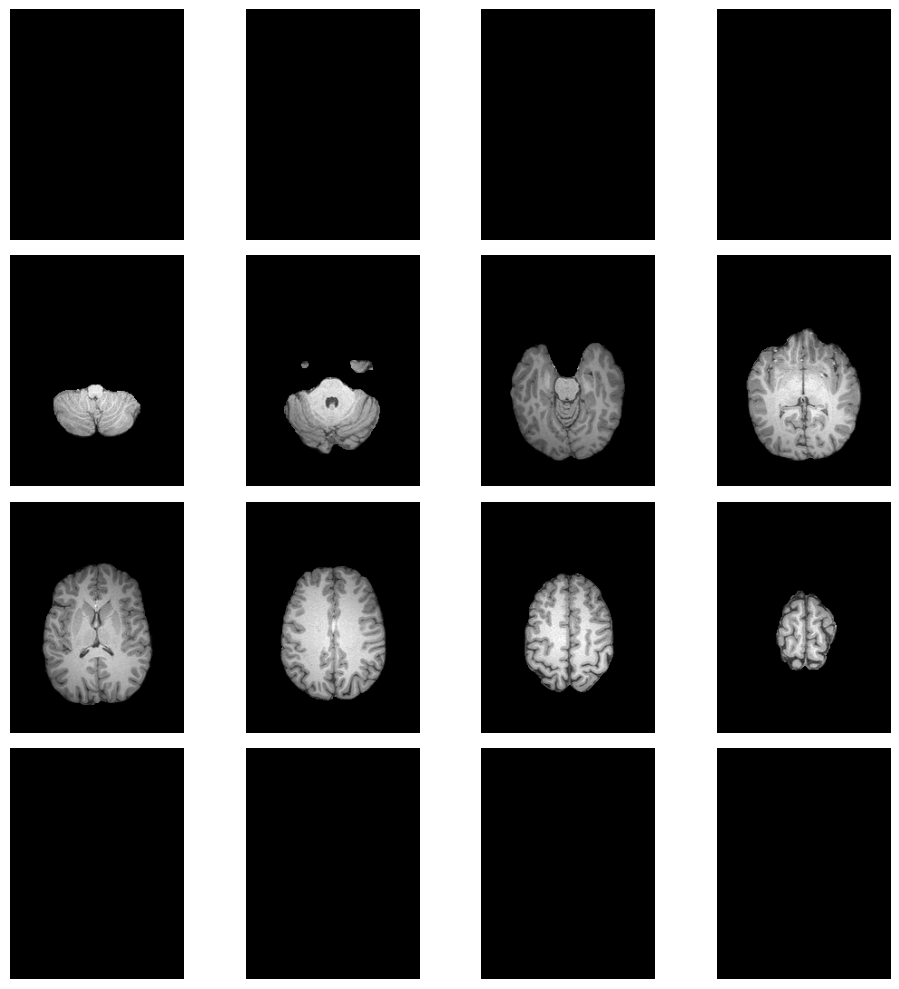

In [ ]:
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    print(img)
    axs.flat[idx].imshow(brain_vol[img, :, :], cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Load data
hc_folder = r"D:\aicte_schiz\COBRE_skullStripped_mprage\COBRE_skullStripped\hc_sample"
sc_folder = r"D:\aicte_schiz\COBRE_skullStripped_mprage\COBRE_skullStripped\sc_sample"
class_0_data = load_nifti(hc_folder)
class_0_labels = np.zeros(len(class_0_data))

class_1_data = load_nifti(sc_folder)
class_1_labels = np.ones(len(class_1_data))

data = np.concatenate([class_0_data, class_1_data], axis=0)
classes = np.concatenate([class_0_labels, class_1_labels], axis=0)

X,y = data, classes

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


In [ ]:
hc = class_0_data[1]
sc = class_1_data[4]

In [ ]:
# figures = [
#     hc[96],
#     sc[96],hc[112],sc[112],hc[128],sc[128]
# ]

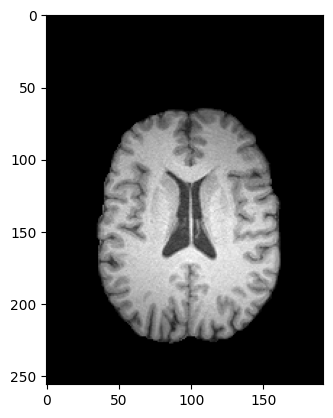

In [ ]:
plt.imshow(hc[128],cmap ="gray")
plt.show()

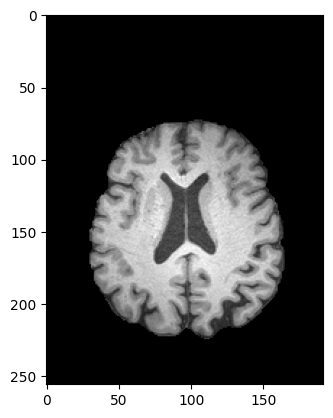

In [ ]:
plt.imshow(sc[154],cmap ="gray")
plt.show()

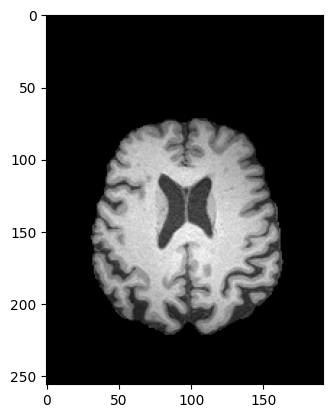

In [ ]:
plt.imshow(sc[160],cmap ="gray")
plt.show()

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(5,6))

for i, ax in enumerate(axs.flat):
    ax.imshow(figures[i],cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [120]:
gm_min = ((np.max(hc)) / 50) * 10
gm_max = ((np.max(hc)) / 50) * 15

In [121]:
brain_mask1 = np.where(hc > gm_min, 1, 0)
brain_mask2 = np.where(hc < gm_max, 1, 0)

In [122]:
brain_mask = brain_mask1 + brain_mask2
brain_mask = np.where(brain_mask == 2, 1, 0)

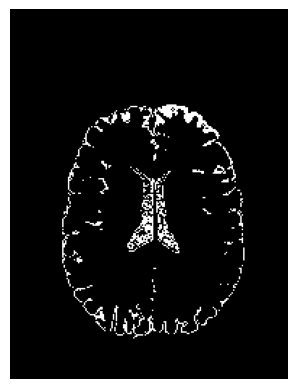

In [124]:
plt.imshow(brain_mask[80, :, :], cmap='gray')
plt.axis('off')
plt.show()

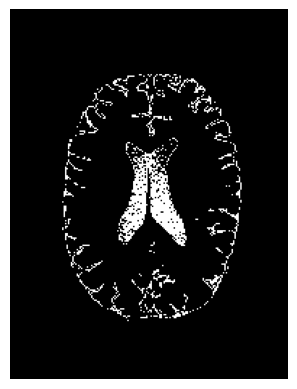

In [127]:
gm_min = ((np.max(sc)) / 50) * 10
gm_max = ((np.max(sc)) / 50) * 15
brain_mask1 = np.where(sc > gm_min, 1, 0)
brain_mask2 = np.where(sc < gm_max, 1, 0)
brain_mask = brain_mask1 + brain_mask2
brain_mask = np.where(brain_mask == 2, 1, 0)
plt.imshow(brain_mask[100, :, :], cmap='gray')
plt.axis('off')
plt.show()

In [107]:
sigma = 2
smoothed = ndi.gaussian_filter(brain_vol, sigma)

NameError: name 'brain_vol' is not defined

In [94]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size

start_stop = int((n_slice - plot_range) / 2)


fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(smoothed[img, :, :], cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'brain_vol' is not defined

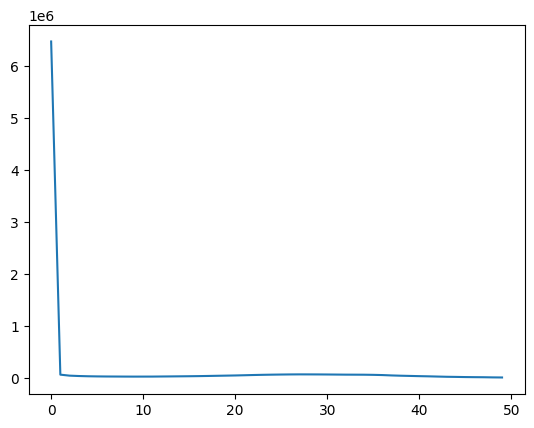

In [128]:
filt = ndi.gaussian_filter(hc, sigma=2)
plt.plot(ndi.histogram(filt, min=0, max=np.max(filt), bins=50))
plt.show()

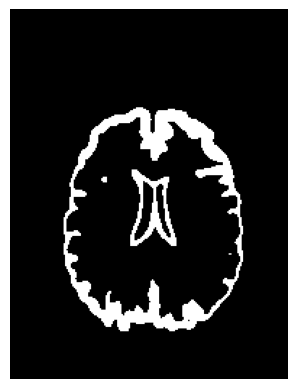

In [129]:
gm_min = ((np.max(filt)) / 50) * 16
gm_max = ((np.max(filt)) / 50) * 25

brain_mask1 = np.where(filt > gm_min, 1, 0)
brain_mask2 = np.where(filt < gm_max, 1, 0)

brain_mask = brain_mask1 + brain_mask2
brain_mask = np.where(brain_mask == 2, 1, 0)

plt.imshow(brain_mask[83, :, :], cmap='gray')
plt.axis('off')
plt.show()

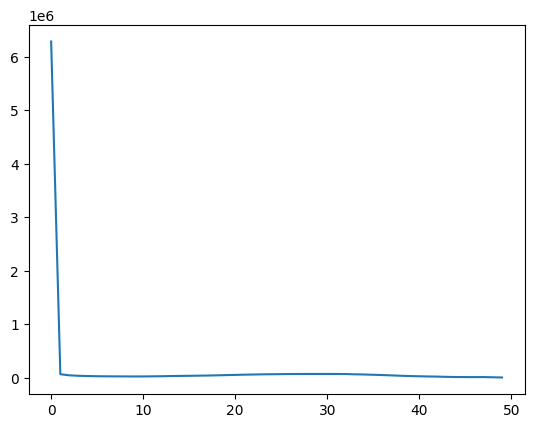

In [130]:
filt = ndi.gaussian_filter(sc, sigma=2)
plt.plot(ndi.histogram(filt, min=0, max=np.max(filt), bins=50))
plt.show()

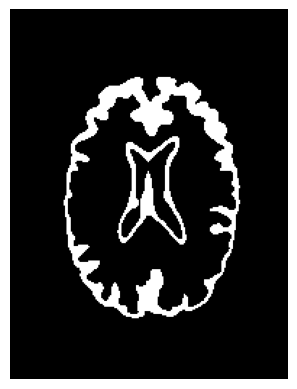

In [131]:
gm_min = ((np.max(filt)) / 50) * 16
gm_max = ((np.max(filt)) / 50) * 25

brain_mask1 = np.where(filt > gm_min, 1, 0)
brain_mask2 = np.where(filt < gm_max, 1, 0)

brain_mask = brain_mask1 + brain_mask2
brain_mask = np.where(brain_mask == 2, 1, 0)

plt.imshow(brain_mask[100, :, :], cmap='gray')
plt.axis('off')
plt.show()